# CIFAR-10 с трюками

В этом задании мы продолжим работать с CIFAR-10, опробовав трюки, про которые мы узнали в 4 модуле.

Датасет CIFAR-10 состоит из цветных картинок 32x32, разделенных на 10 классов: 

__airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck__

# Импорты

In [6]:
!pip3 install --upgrade pip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [11]:
!pip install https://storage.googleapis.com/tensorflow/linux/gpu/tensorflow-2.12.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.6 MB/s eta 0:00:00


In [12]:
# !pip3 install -q tensorflow==2.1.0

In [13]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)

2.12.0
2.12.0


# Загружаем данные

In [14]:
from tensorflow.keras.datasets import cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 13s 0us/step


In [15]:
print("Трейн:", x_train.shape, y_train.shape)
print("Тест:", x_test.shape, y_test.shape)

Трейн: (50000, 32, 32, 3) (50000, 1)
Тест: (10000, 32, 32, 3) (10000, 1)


In [16]:
NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

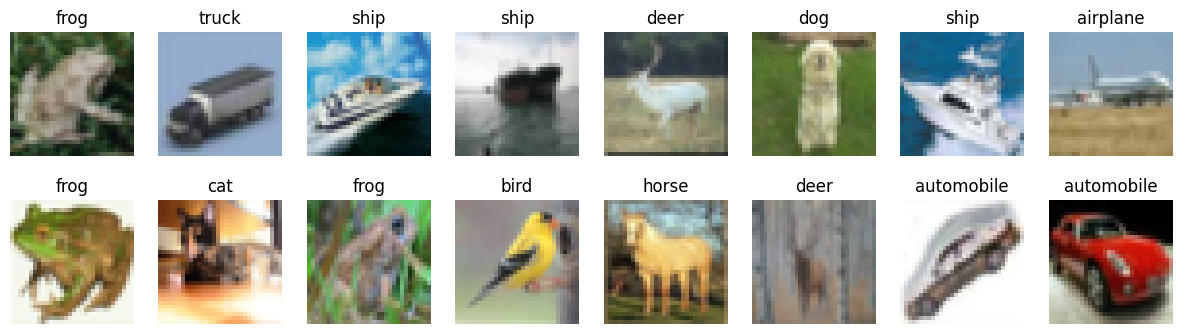

In [17]:
# посмотрим на примеры картинок
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index, 0]])
plt.show()

# Готовим данные

Не забудьте нормализовать картинки: $$x_{norm} = \frac{x}{255} - 0.5$$

А еще нужно превратить метки в one-hot вектора при помощи __keras.utils.to_categorical__.

In [18]:
# нормализуем входы
x_train2 = x_train.astype('float32') / 255 - 0.5
x_test2 = x_test.astype('float32') / 255 - 0.5

# конвертируем метки в np.array (?, NUM_CLASSES)
y_train2 = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test2 = keras.utils.to_categorical(y_test, NUM_CLASSES)

# Задаем *дефолтную* архитектуру сети

In [19]:
# слои, которые нам пригодятся
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

Нам понадобятся такие слои:
- [Conv2D](https://keras.io/layers/convolutional/#conv2d) - сверточный слой:
    - **filters**: количество фильтров на выходе; 
    - **kernel_size**: размер скользящего окна;
    - **padding**: padding="same" добивает нулями, чтобы ширина и высота на выходе не изменились, padding='valid' берет только окна, которые полностью помещаются в картинке;
    - **activation**: "relu", "tanh", итд;
    - **input_shape**: размер входа вида (W, H, C_in).
- [MaxPooling2D](https://keras.io/layers/pooling/#maxpooling2d) - пулинг
- [Flatten](https://keras.io/layers/core/#flatten) - все оси, кроме батча (первой) вытягиваются в один вектор.
- [Dense](https://keras.io/layers/core/#dense) - плотный, активацию можно задать через activation="elu" или activation="softmax".
- [Dropout](https://keras.io/layers/core/#dropout) - дропаут регуляризация (без нее сеть сильно переобучается), позже узнаем какой у нее смысл.

Ваша модель должна принимать на вход цветную картинку __(None, 32, 32, 3)__ и предсказывать вероятности 10 классов __(None, 10)__.

Добавьте __4__ сверточных слоя с окном __(3, 3)__ с нарастающим количеством фильтров: __(16, 32, 32, 64)__, используйте "same" паддинг.

Добавьте __2x2__ макс пулинг после каждых 2 сверточных слоев (conv-conv-pool схема).

Используйте __activation='relu'__ для всех слоев, где это нужно.

Добавьте плотный слой из __256__ нейронов и еще один из __10__ нейронов для предсказания выходов. Не забудьте применить __Flatten__ перед первым плотным слоем!

Для регуляризации сети вставьте Dropout после каждого пулинг слоя (с параметром** 0.25**) и между плотными слоями на выходе (с параметром **0.5**).

В дальнейшем будем называть эту архитектуру **дефолтной** и будем исследовать небольшие изменения в ней!

In [28]:
def make_default_model():
    model = Sequential([
            keras.Input(shape = (32, 32, 3)),
            Conv2D(16, (3, 3), activation = 'relu', padding="same"),
            Conv2D(32, (3, 3), activation = 'relu', padding="same"),
            MaxPooling2D(pool_size=(2, 2)),
            Dropout(0.25),
            Conv2D(32, (3, 3), activation = 'relu', padding="same"),    
            Conv2D(64, (3, 3), activation = 'relu', padding="same"),  
            MaxPooling2D(pool_size=(2, 2)),  
            Dropout(0.25),
            Flatten(),
            Dense(256, activation = 'relu'),
            Dropout(0.5),
            Dense(10, activation = 'softmax')
    ])
    
    return model

In [23]:
K.clear_session()
model = make_default_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 64)        18496     
                                                        

# Тренируем модель

In [24]:
def train_model(make_model_func=make_default_model, optimizer="adam"):
  BATCH_SIZE = 32
  EPOCHS = 10

  K.clear_session()
  model = make_model_func()

  model.compile(
      loss='categorical_crossentropy',
      optimizer=optimizer,
      metrics=['accuracy']
  )

  model.fit(
      x_train2, y_train2,  # нормализованные данные
      batch_size=BATCH_SIZE,
      epochs=EPOCHS,
      validation_data=(x_test2, y_test2),
      shuffle=False
  )
  
  return model

Давайте посмотрим, что будет с дефолтной моделью (модель = make_default_model, оптимайзер = "adam"), если ее немного поменять:


Часть 1 :
1.   Какое качество (accuracy) на валидации дает **дефолтная архитектура**?

Часть 2:
2.   Измените в дефолтной архитектуре **relu активацию на sigmoid**, какое качество на валидации получили?
3.   Измените в дефолтной архитектуре **adam оптимайзер на sgd**, какое качество на валидации получили?
4.   Добавьте к дефолтной архитектуре **батч нормализацию** после каждого сверточного слоя и после перового полносвязного (model.add(BatchNormalization())), какое качество на валидации получили?
5.   Добавьте к дефолтной архитектуре **батч нормализацию** и смените **relu активацию на sigmoid**,  какое качество на валидации получили?
  
*Рекомендуется завести свою функцию для каждого изменения архитектуры!*


In [25]:
# учим дефолтную архитектуру
train_model()

Epoch 1/10
1563/1563 [==============================] - 24s 7ms/step - loss: 1.4668 - accuracy: 0.4678 - val_loss: 1.0716 - val_accuracy: 0.6224
Epoch 2/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.0877 - accuracy: 0.6149 - val_loss: 0.8884 - val_accuracy: 0.6893
Epoch 3/10
1563/1563 [==============================] - 10s 7ms/step - loss: 0.9420 - accuracy: 0.6686 - val_loss: 0.8212 - val_accuracy: 0.7092
Epoch 4/10
1563/1563 [==============================] - 11s 7ms/step - loss: 0.8499 - accuracy: 0.7015 - val_loss: 0.7649 - val_accuracy: 0.7306
Epoch 5/10
1563/1563 [==============================] - 10s 6ms/step - loss: 0.7857 - accuracy: 0.7223 - val_loss: 0.7627 - val_accuracy: 0.7336
Epoch 6/10
1563/1563 [==============================] - 12s 7ms/step - loss: 0.7311 - accuracy: 0.7441 - val_loss: 0.7152 - val_accuracy: 0.7513
Epoch 7/10
1563/1563 [==============================] - 14s 9ms/step - loss: 0.6920 - accuracy: 0.7537 - val_loss: 0.7479 - val_ac

In [26]:
def make_sigmoid_model():
    model = Sequential([
            keras.Input(shape = (32, 32, 3)),
            Conv2D(16, (3, 3), activation = 'sigmoid', padding="same"),
            Conv2D(32, (3, 3), activation = 'sigmoid', padding="same"),
            MaxPooling2D(pool_size=(2, 2)),
            Dropout(0.25),
            Conv2D(32, (3, 3), activation = 'sigmoid', padding="same"),    
            Conv2D(64, (3, 3), activation = 'sigmoid', padding="same"),  
            MaxPooling2D(pool_size=(2, 2)),  
            Dropout(0.25),
            Flatten(),
            Dense(256, activation = 'sigmoid'),
            Dropout(0.5),
            Dense(10, activation = 'softmax')
    ])
    
    return model

In [27]:
# учим sigmoid
train_model(make_sigmoid_model)

Epoch 1/10
1563/1563 [==============================] - 13s 7ms/step - loss: 2.3181 - accuracy: 0.0987 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 2/10
1563/1563 [==============================] - 9s 6ms/step - loss: 2.3035 - accuracy: 0.0984 - val_loss: 2.3030 - val_accuracy: 0.1000
Epoch 3/10
1563/1563 [==============================] - 12s 7ms/step - loss: 2.3044 - accuracy: 0.0979 - val_loss: 2.3031 - val_accuracy: 0.1000
Epoch 4/10
1563/1563 [==============================] - 11s 7ms/step - loss: 2.3061 - accuracy: 0.0975 - val_loss: 2.3185 - val_accuracy: 0.1000
Epoch 5/10
1563/1563 [==============================] - 11s 7ms/step - loss: 2.3119 - accuracy: 0.1022 - val_loss: 2.3058 - val_accuracy: 0.1000
Epoch 6/10
1563/1563 [==============================] - 11s 7ms/step - loss: 2.3077 - accuracy: 0.1001 - val_loss: 2.3048 - val_accuracy: 0.1000
Epoch 7/10
1563/1563 [==============================] - 10s 6ms/step - loss: 2.3069 - accuracy: 0.0997 - val_loss: 2.3050 - val_acc

In [29]:
# учим sgd
train_model(optimizer="sgd")

Epoch 1/10
1563/1563 [==============================] - 12s 6ms/step - loss: 2.0345 - accuracy: 0.2540 - val_loss: 1.7557 - val_accuracy: 0.3839
Epoch 2/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.7037 - accuracy: 0.3853 - val_loss: 1.4968 - val_accuracy: 0.4620
Epoch 3/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.5311 - accuracy: 0.4449 - val_loss: 1.3668 - val_accuracy: 0.5100
Epoch 4/10
1563/1563 [==============================] - 9s 6ms/step - loss: 1.4146 - accuracy: 0.4895 - val_loss: 1.2709 - val_accuracy: 0.5416
Epoch 5/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.3311 - accuracy: 0.5240 - val_loss: 1.1940 - val_accuracy: 0.5695
Epoch 6/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.2527 - accuracy: 0.5511 - val_loss: 1.1411 - val_accuracy: 0.5938
Epoch 7/10
1563/1563 [==============================] - 10s 6ms/step - loss: 1.1967 - accuracy: 0.5715 - val_loss: 1.1131 - val_accu

In [30]:
def make_bn_model():
    model = Sequential([
            keras.Input(shape = (32, 32, 3)),
            Conv2D(16, (3, 3), activation = 'relu', padding="same"),
            BatchNormalization(),
            Conv2D(32, (3, 3), activation = 'relu', padding="same"),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2)),
            Dropout(0.25),
            Conv2D(32, (3, 3), activation = 'relu', padding="same"),    
            BatchNormalization(),
            Conv2D(64, (3, 3), activation = 'relu', padding="same"),  
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2)),  
            Dropout(0.25),
            Flatten(),
            Dense(256, activation = 'relu'),
            BatchNormalization(),
            Dropout(0.5),
            Dense(10, activation = 'softmax')
    ])
    
    return model

In [31]:
# учим bn
train_model(make_bn_model)

Epoch 1/10
1563/1563 [==============================] - 18s 9ms/step - loss: 1.5031 - accuracy: 0.4830 - val_loss: 0.9954 - val_accuracy: 0.6472
Epoch 2/10
1563/1563 [==============================] - 13s 9ms/step - loss: 1.0403 - accuracy: 0.6345 - val_loss: 0.8510 - val_accuracy: 0.6992
Epoch 3/10
1563/1563 [==============================] - 14s 9ms/step - loss: 0.8955 - accuracy: 0.6856 - val_loss: 0.9101 - val_accuracy: 0.6851
Epoch 4/10
1563/1563 [==============================] - 15s 9ms/step - loss: 0.8072 - accuracy: 0.7177 - val_loss: 0.6977 - val_accuracy: 0.7550
Epoch 5/10
1563/1563 [==============================] - 15s 10ms/step - loss: 0.7357 - accuracy: 0.7437 - val_loss: 0.6495 - val_accuracy: 0.7744
Epoch 6/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.6778 - accuracy: 0.7637 - val_loss: 0.6546 - val_accuracy: 0.7737
Epoch 7/10
1563/1563 [==============================] - 17s 11ms/step - loss: 0.6328 - accuracy: 0.7792 - val_loss: 0.6177 - val

In [32]:
def make_sigmoid_bn_model():
    model = Sequential([
            keras.Input(shape = (32, 32, 3)),
            Conv2D(16, (3, 3), activation = 'sigmoid', padding="same"),
            BatchNormalization(),
            Conv2D(32, (3, 3), activation = 'sigmoid', padding="same"),
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2)),
            Dropout(0.25),
            Conv2D(32, (3, 3), activation = 'sigmoid', padding="same"),    
            BatchNormalization(),
            Conv2D(64, (3, 3), activation = 'sigmoid', padding="same"),  
            BatchNormalization(),
            MaxPooling2D(pool_size=(2, 2)),  
            Dropout(0.25),
            Flatten(),
            Dense(256, activation = 'sigmoid'),
            BatchNormalization(),
            Dropout(0.5),
            Dense(10, activation = 'softmax')
    ])
    
    return model

In [33]:
# учим sigmoid + bn
train_model(make_sigmoid_bn_model)

Epoch 1/10
1563/1563 [==============================] - 18s 9ms/step - loss: 1.5709 - accuracy: 0.4440 - val_loss: 1.3196 - val_accuracy: 0.5553
Epoch 2/10
1563/1563 [==============================] - 14s 9ms/step - loss: 1.2044 - accuracy: 0.5733 - val_loss: 1.0294 - val_accuracy: 0.6378
Epoch 3/10
1563/1563 [==============================] - 14s 9ms/step - loss: 1.0667 - accuracy: 0.6276 - val_loss: 1.0295 - val_accuracy: 0.6362
Epoch 4/10
1563/1563 [==============================] - 14s 9ms/step - loss: 0.9839 - accuracy: 0.6565 - val_loss: 0.8675 - val_accuracy: 0.6981
Epoch 5/10
1563/1563 [==============================] - 14s 9ms/step - loss: 0.9240 - accuracy: 0.6751 - val_loss: 0.8127 - val_accuracy: 0.7149
Epoch 6/10
1563/1563 [==============================] - 13s 8ms/step - loss: 0.8786 - accuracy: 0.6934 - val_loss: 0.8037 - val_accuracy: 0.7203
Epoch 7/10
1563/1563 [==============================] - 13s 9ms/step - loss: 0.8396 - accuracy: 0.7082 - val_loss: 0.8035 - val_ac